# Self-Driving Car Engineer Nanodegree

## Project 4: Advaned Laneline Detection
---

## Goals

Dtetect lane lines and calculate curvatures.

## Steps

1. Camera Calibration
2. Distortion correction
3. Color and gradient threshold
4. Warp perspective transform

### Camera Calibration

1. Convert color image to grayscale
2. Find corners
3. Get calibration matrix

In [2]:
### TODO:
# 1. Count nx and ny
# 2. Convert color image to grayscale
# 3. Get corners


import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt


# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


### Distortion Correction

Execute calibration and distortion correction once. Save the results for later usage.

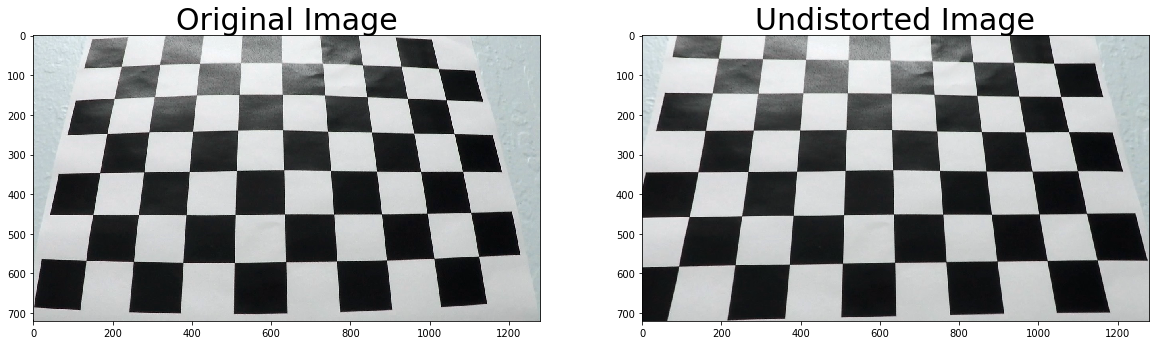

In [3]:
###

import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration3_test_undist.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Color & Gradient Threshold

Create a pipeline to process an image.

#### Define some preprocessing functions below

In [1]:
###

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


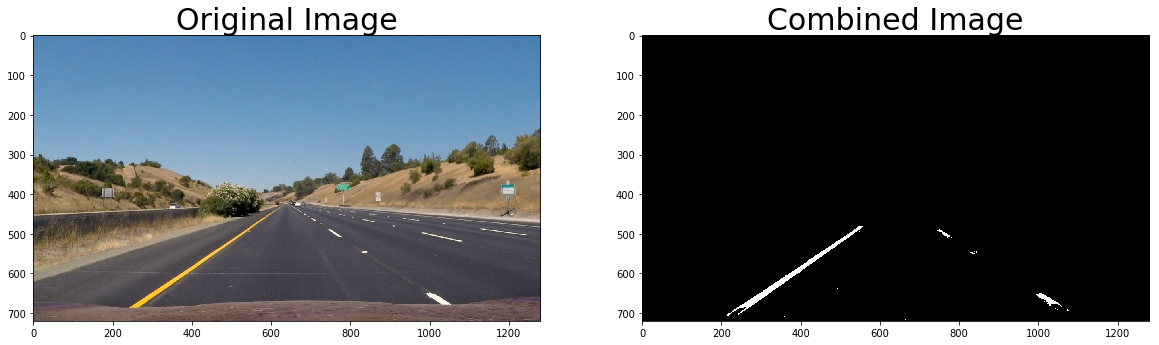

In [2]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Load a test image
img = mpimg.imread('test_images/straight_lines1.jpg')

imshape = img.shape
vertices = np.array([[(50,imshape[0]),(500, 480), (800,480), (1200,imshape[0])]], dtype=np.int32)

# Undistortion
dst = cv2.undistort(img, mtx, dist, None, mtx)

# grayscale image
gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)

# sobel operation applied to x axis
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

# Get absolute values
abs_sobelx = np.absolute(sobelx)

# Scale to (0, 255)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# threshold
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
# plt.imshow(sxbinary, cmap='gray')


# Get HLS color image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)

# Get s-channel
s_channel = hls[:, :, 2]

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1


# Combine grayscale and color gradient
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

combined_binary = region_of_interest(combined_binary, vertices)

kernel_size = 5
combined_binary = gaussian_blur(combined_binary, kernel_size)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined Image', fontsize=30)

### Warp perspective

Test the warped area

1280 720


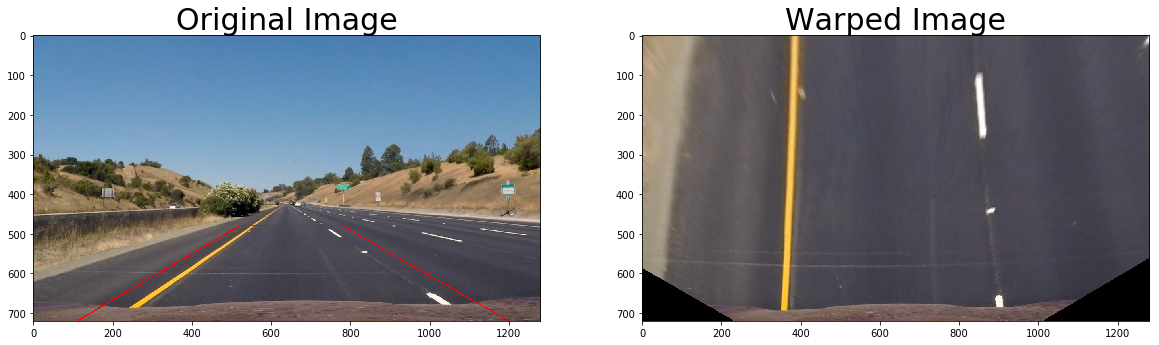

In [28]:
height = combined_binary.shape[0]
width = combined_binary.shape[1]
print(width, height)


# Set the view of perspective
pts_list = [[110,height],[520, 480], [780,480], [1200,height]]
pts = np.array(pts_list, np.int32)
pts = pts.reshape((-1,1,2))
tmp = np.copy(img)
# Draw the ROI on the image
cv2.polylines(tmp,[pts],True,(255,0,0), thickness=2)

points_src = np.float32([pts_list])
points_dst = np.float32([[300,height],[300,0],[960,0],[960,height]])

M = cv2.getPerspectiveTransform(points_src, points_dst)
warped = cv2.warpPerspective(img, M, (width, height))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(tmp)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)